<a href="https://colab.research.google.com/github/IceCao/DomainSpasial/blob/main/DomainSpasial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

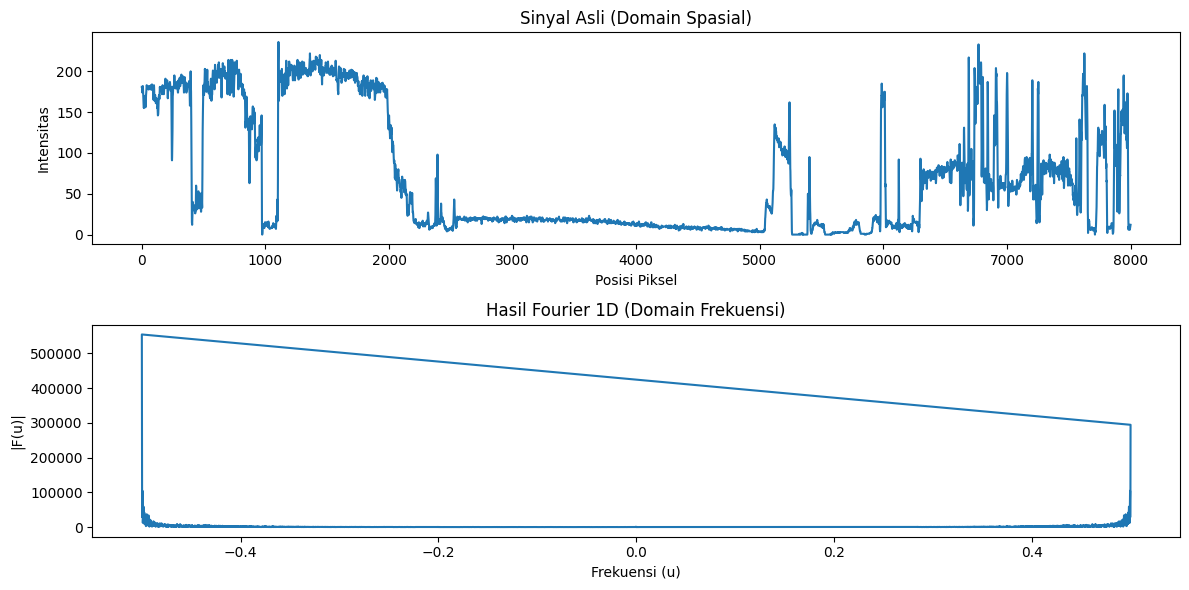

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Baca gambar grayscale
img = cv2.imread('gambar-1.jpg', 0)

# 2. Ambil satu baris (misal baris ke-100) sebagai sinyal 1D
row = img[100, :]   # sinyal spasial 1D

# 3. Lakukan Fourier Transform 1D
F = np.fft.fft(row)
Fshift = np.fft.fftshift(F)

# 4. Hitung magnitude spectrum
magnitude = np.abs(Fshift)
freq = np.fft.fftfreq(len(row))

# 5. Tampilkan hasil
plt.figure(figsize=(12,6))


plt.subplot(2,1,1)
plt.plot(row)
plt.title('Sinyal Asli (Domain Spasial)')
plt.xlabel('Posisi Piksel')
plt.ylabel('Intensitas')

plt.subplot(2,1,2)
plt.plot(freq, magnitude)
plt.title('Hasil Fourier 1D (Domain Frekuensi)')
plt.xlabel('Frekuensi (u)')
plt.ylabel('|F(u)|')
plt.tight_layout()
plt.show()

Gambar ditemukan dan dimuat.


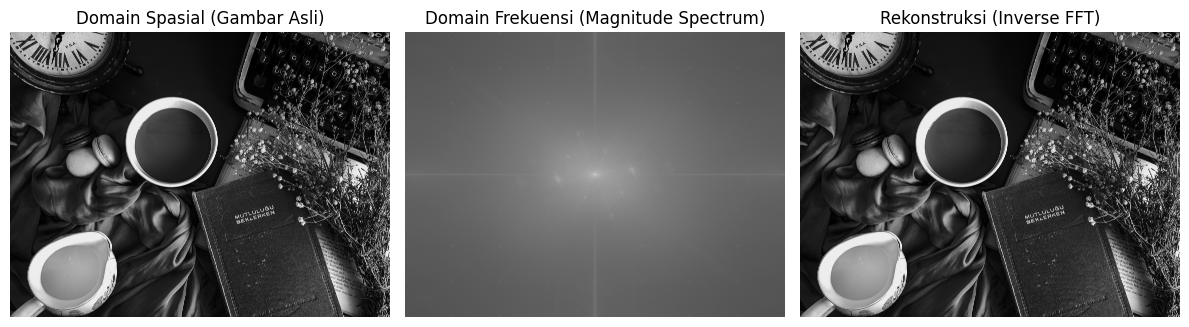

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- 1. Membaca gambar (gunakan gambar sendiri atau buat checkerboard sintetis) ---
def load_or_generate_image():
    try:
        img = Image.open("gambar-1.jpg").convert("L")  # ubah ke grayscale
        print("Gambar ditemukan dan dimuat.")
    except:
        print("Tidak ditemukan gambar, membuat gambar checkerboard sintetis...")
        n = 256
        freq = 8
        x = np.arange(n)
        y = np.arange(n)
        xv, yv = np.meshgrid(x, y)
        checker = ((xv // (n // freq) + yv // (n // freq)) % 2) * 255
        img = Image.fromarray(checker.astype(np.uint8))
    return np.array(img, dtype=float)

# --- 2. Mengubah domain spasial ke domain frekuensi ---
def spatial_to_frequency(img_gray):
    # FFT 2D
    F = np.fft.fft2(img_gray)
    # Geser titik nol ke tengah
    F_shift = np.fft.fftshift(F)
    # Hitung magnitude spectrum
    magnitude_spectrum = np.log1p(np.abs(F_shift))
    return F_shift, magnitude_spectrum

# --- 3. Mengubah kembali ke domain spasial (inverse FFT) ---
def frequency_to_spatial(F_shift):
    F_ishift = np.fft.ifftshift(F_shift)
    img_reconstructed = np.fft.ifft2(F_ishift)
    return np.real(img_reconstructed)

# --- 4. Menjalankan proses ---
img_gray = load_or_generate_image()
F_shift, magnitude_spectrum = spatial_to_frequency(img_gray)
img_reconstructed = frequency_to_spatial(F_shift)

# --- 5. Menampilkan hasil ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Domain Spasial (Gambar Asli)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Domain Frekuensi (Magnitude Spectrum)')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_reconstructed, cmap='gray')
plt.title('Rekonstruksi (Inverse FFT)')
plt.axis('off')

plt.tight_layout()
plt.show()


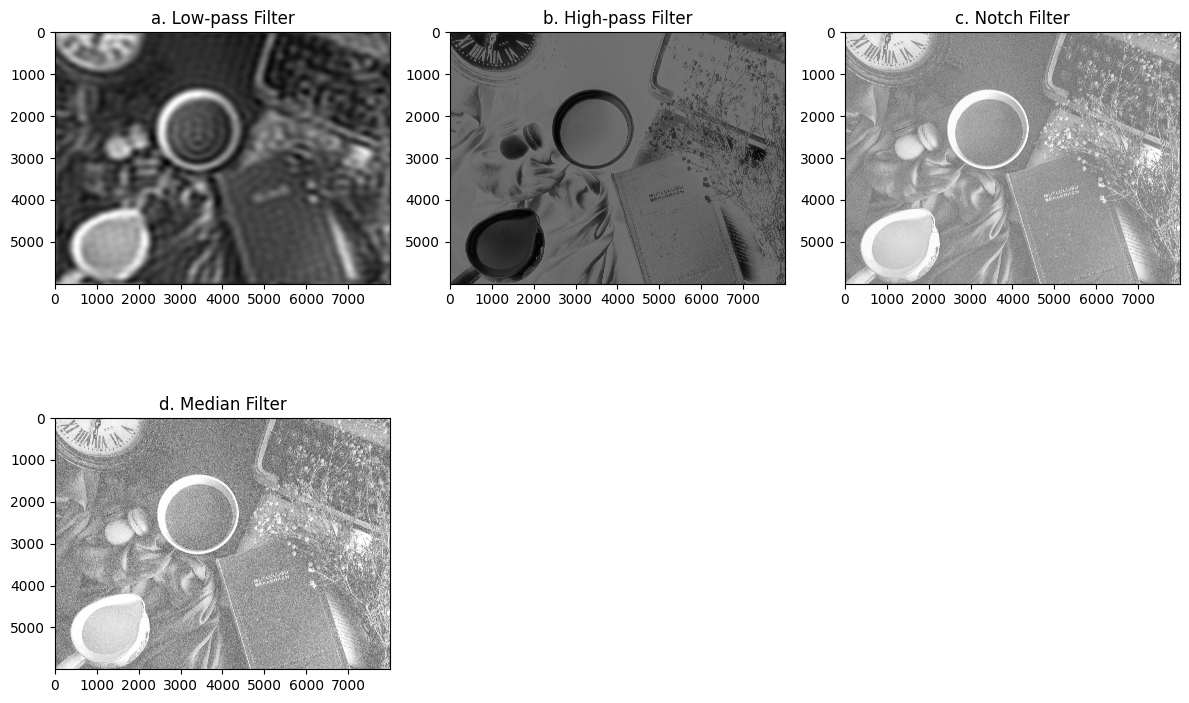

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ================== 1. Load / Generate Gambar ==================
def load_or_generate_image():
    # Gunakan citra grayscale bawaan
    img = cv2.imread(cv2.samples.findFile('gambar-1.jpg'), cv2.IMREAD_GRAYSCALE)
    if img is None:
        # Jika tidak ada, buat gambar sintetik
        img = np.zeros((256, 256), dtype=np.uint8)
        cv2.putText(img, 'NOISE', (50, 130), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 5, cv2.LINE_AA)
    # Tambahkan noise gaussian
    noise = np.random.normal(0, 25, img.shape).astype(np.uint8)
    noisy_img = cv2.add(img, noise)
    return noisy_img

# ================== 2. Fungsi FFT dan IFFT ==================
def fft_image(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return fshift

def ifft_image(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

# ================== 3. Filter Frequency Domain ==================
def low_pass_filter(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), cutoff, 1, thickness=-1)
    return mask

def high_pass_filter(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), cutoff, 0, thickness=-1)
    return mask

def notch_filter(shape, center1, center2, radius=10):
    rows, cols = shape
    mask = np.ones((rows, cols), np.uint8)
    cv2.circle(mask, center1, radius, 0, -1)
    cv2.circle(mask, center2, radius, 0, -1)
    return mask

# ================== 4. Median Filter ==================
def median_filter(img, ksize=3):
    return cv2.medianBlur(img, ksize)

# ================== 5. Proses dan Visualisasi ==================
img_noisy = load_or_generate_image()
F_shift = fft_image(img_noisy)

# a. Low-pass
mask_low = low_pass_filter(img_noisy.shape, cutoff=30)
F_low = F_shift * mask_low
img_low = ifft_image(F_low)

# b. High-pass
mask_high = high_pass_filter(img_noisy.shape, cutoff=30)
F_high = F_shift * mask_high
img_high = ifft_image(F_high)

# c. Notch filter (contoh dua titik noise)
mask_notch = notch_filter(img_noisy.shape, (128 + 20, 128), (128 - 20, 128), radius=10)
F_notch = F_shift * mask_notch
img_notch = ifft_image(F_notch)

# d. Median filter (spasial)
img_median = median_filter(img_noisy, ksize=3)

# ================== 6. Plot ==================
plt.figure(figsize=(12, 8))
# plt.subplot(2, 3, 1), plt.imshow(img_noisy, cmap='gray'), plt.title('Citra Berisik')
plt.subplot(2, 3, 1), plt.imshow(img_low, cmap='gray'), plt.title('a. Low-pass Filter')
plt.subplot(2, 3, 2), plt.imshow(img_high, cmap='gray'), plt.title('b. High-pass Filter')
plt.subplot(2, 3, 3), plt.imshow(img_notch, cmap='gray'), plt.title('c. Notch Filter')
plt.subplot(2, 3, 4), plt.imshow(img_median, cmap='gray'), plt.title('d. Median Filter')
plt.tight_layout()
plt.show()
